In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = r"C:\Users\bucze\snotel-data\station-366-brighton-ut.csv"

df = pd.read_csv(
    file_path,
    comment="#",          # ignore NRCS metadata block
    parse_dates=["Date"]  # parse dates immediately
)

In [5]:
print(df.columns)
df.head()

Index(['Date', 'Snow Water Equivalent (in) Start of Day Values',
       'Precipitation Accumulation (in) Start of Day Values',
       'Air Temperature Maximum (degF)', 'Air Temperature Minimum (degF)',
       'Air Temperature Average (degF)', 'Precipitation Increment (in)'],
      dtype='object')


,Date,Snow Water Equivalent (in) Start of Day Values,Precipitation Accumulation (in) Start of Day Values,Air Temperature Maximum (degF),Air Temperature Minimum (degF),Air Temperature Average (degF),Precipitation Increment (in)
0,1986-09-24,0.0,0.0,NaN,NaN,NaN,0.9
1,1986-09-25,0.5,0.9,NaN,NaN,NaN,0.0
2,1986-09-26,0.7,0.9,NaN,NaN,NaN,0.3
3,1986-09-27,1.1,1.2,NaN,NaN,NaN,0.6
4,1986-09-28,1.6,1.8,NaN,NaN,NaN,0.0


In [6]:
def clean_snotel_csv(df):
    df = df.rename(columns={
        "Date": "date",
        "Snow Water Equivalent (in) Start of Day Values": "swe_in",
        "Precipitation Increment (in)": "prcp_in"
    })

    # Convert numeric columns
    for col in ["swe_in", "prcp_in"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Do I want to drop missing data?
    # Drop rows with missing SWE
    df = df.dropna(subset=["swe_in"])

    return df.sort_values("date").reset_index(drop=True)


In [7]:
df = clean_snotel_csv(df)

In [8]:
def calculate_daily_snowfall_from_swe(df, snow_ratio=10):
    """
    snow_ratio = 10 assumes 10:1 snow-to-liquid ratio
    """
    df["daily_swe_change"] = df["swe_in"].diff()

    # Keep accumulation only
    df["daily_swe_change"] = df["daily_swe_change"].clip(lower=0)

    # Convert SWE to snowfall
    df["daily_snowfall_in"] = df["daily_swe_change"] * snow_ratio

    return df

# Can later test sensitivity 8:1 vs 12:1 snow to rainfall, currently at 10

In [9]:
df = calculate_daily_snowfall_from_swe(df)

In [10]:
POWDER_THRESHOLD_IN = 4.0

df["powder_day"] = df["daily_snowfall_in"] >= POWDER_THRESHOLD_IN
df["day_of_year"] = df["date"].dt.dayofyear


In [11]:
# daily probability at brighton
brighton_daily_prob = (
    df.groupby("day_of_year")["powder_day"]
    .mean()
    .mul(100)
)


In [12]:
# smooth results - optional
brighton_daily_prob_smoothed = (
    brighton_daily_prob
    .rolling(window=7, center=True)
    .mean()
)

In [14]:
# define x, y
y = brighton_daily_prob_smoothed.values
x = np.arange(1, len(y) + 1)

In [15]:
# define figure size
plt.figure(figsize=(6, 11), dpi=200)

<Figure size 1200x2200 with 0 Axes>

<Figure size 1200x2200 with 0 Axes>

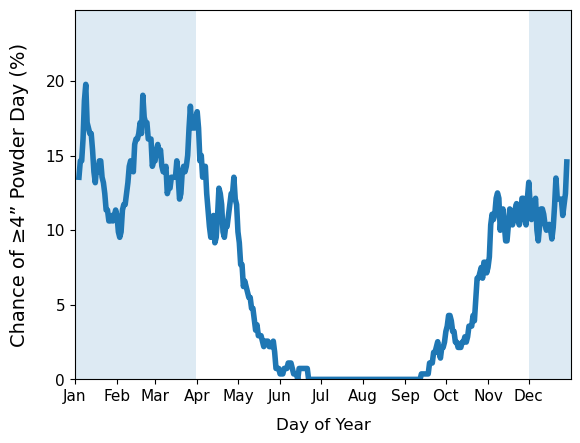

In [22]:
# plot x, y
plt.plot(
    x,
    y,
    linewidth=4
)
plt.ylim(0, np.nanmax(y) + 5)
plt.xlim(1, 366)

# x, y labels
plt.ylabel("Chance of ≥4” Powder Day (%)", fontsize=14, labelpad=12)
plt.xlabel("Day of Year", fontsize=12, labelpad=10)

# convert day number to month
month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.xticks(month_days, month_labels, fontsize=11)
plt.yticks(fontsize=11)

# highlight core powder season
plt.axvspan(335, 366, alpha=0.15)
plt.axvspan(1, 90, alpha=0.15)


In [23]:
# figure annotation
peak_day = x[np.nanargmax(y)]
peak_value = np.nanmax(y)

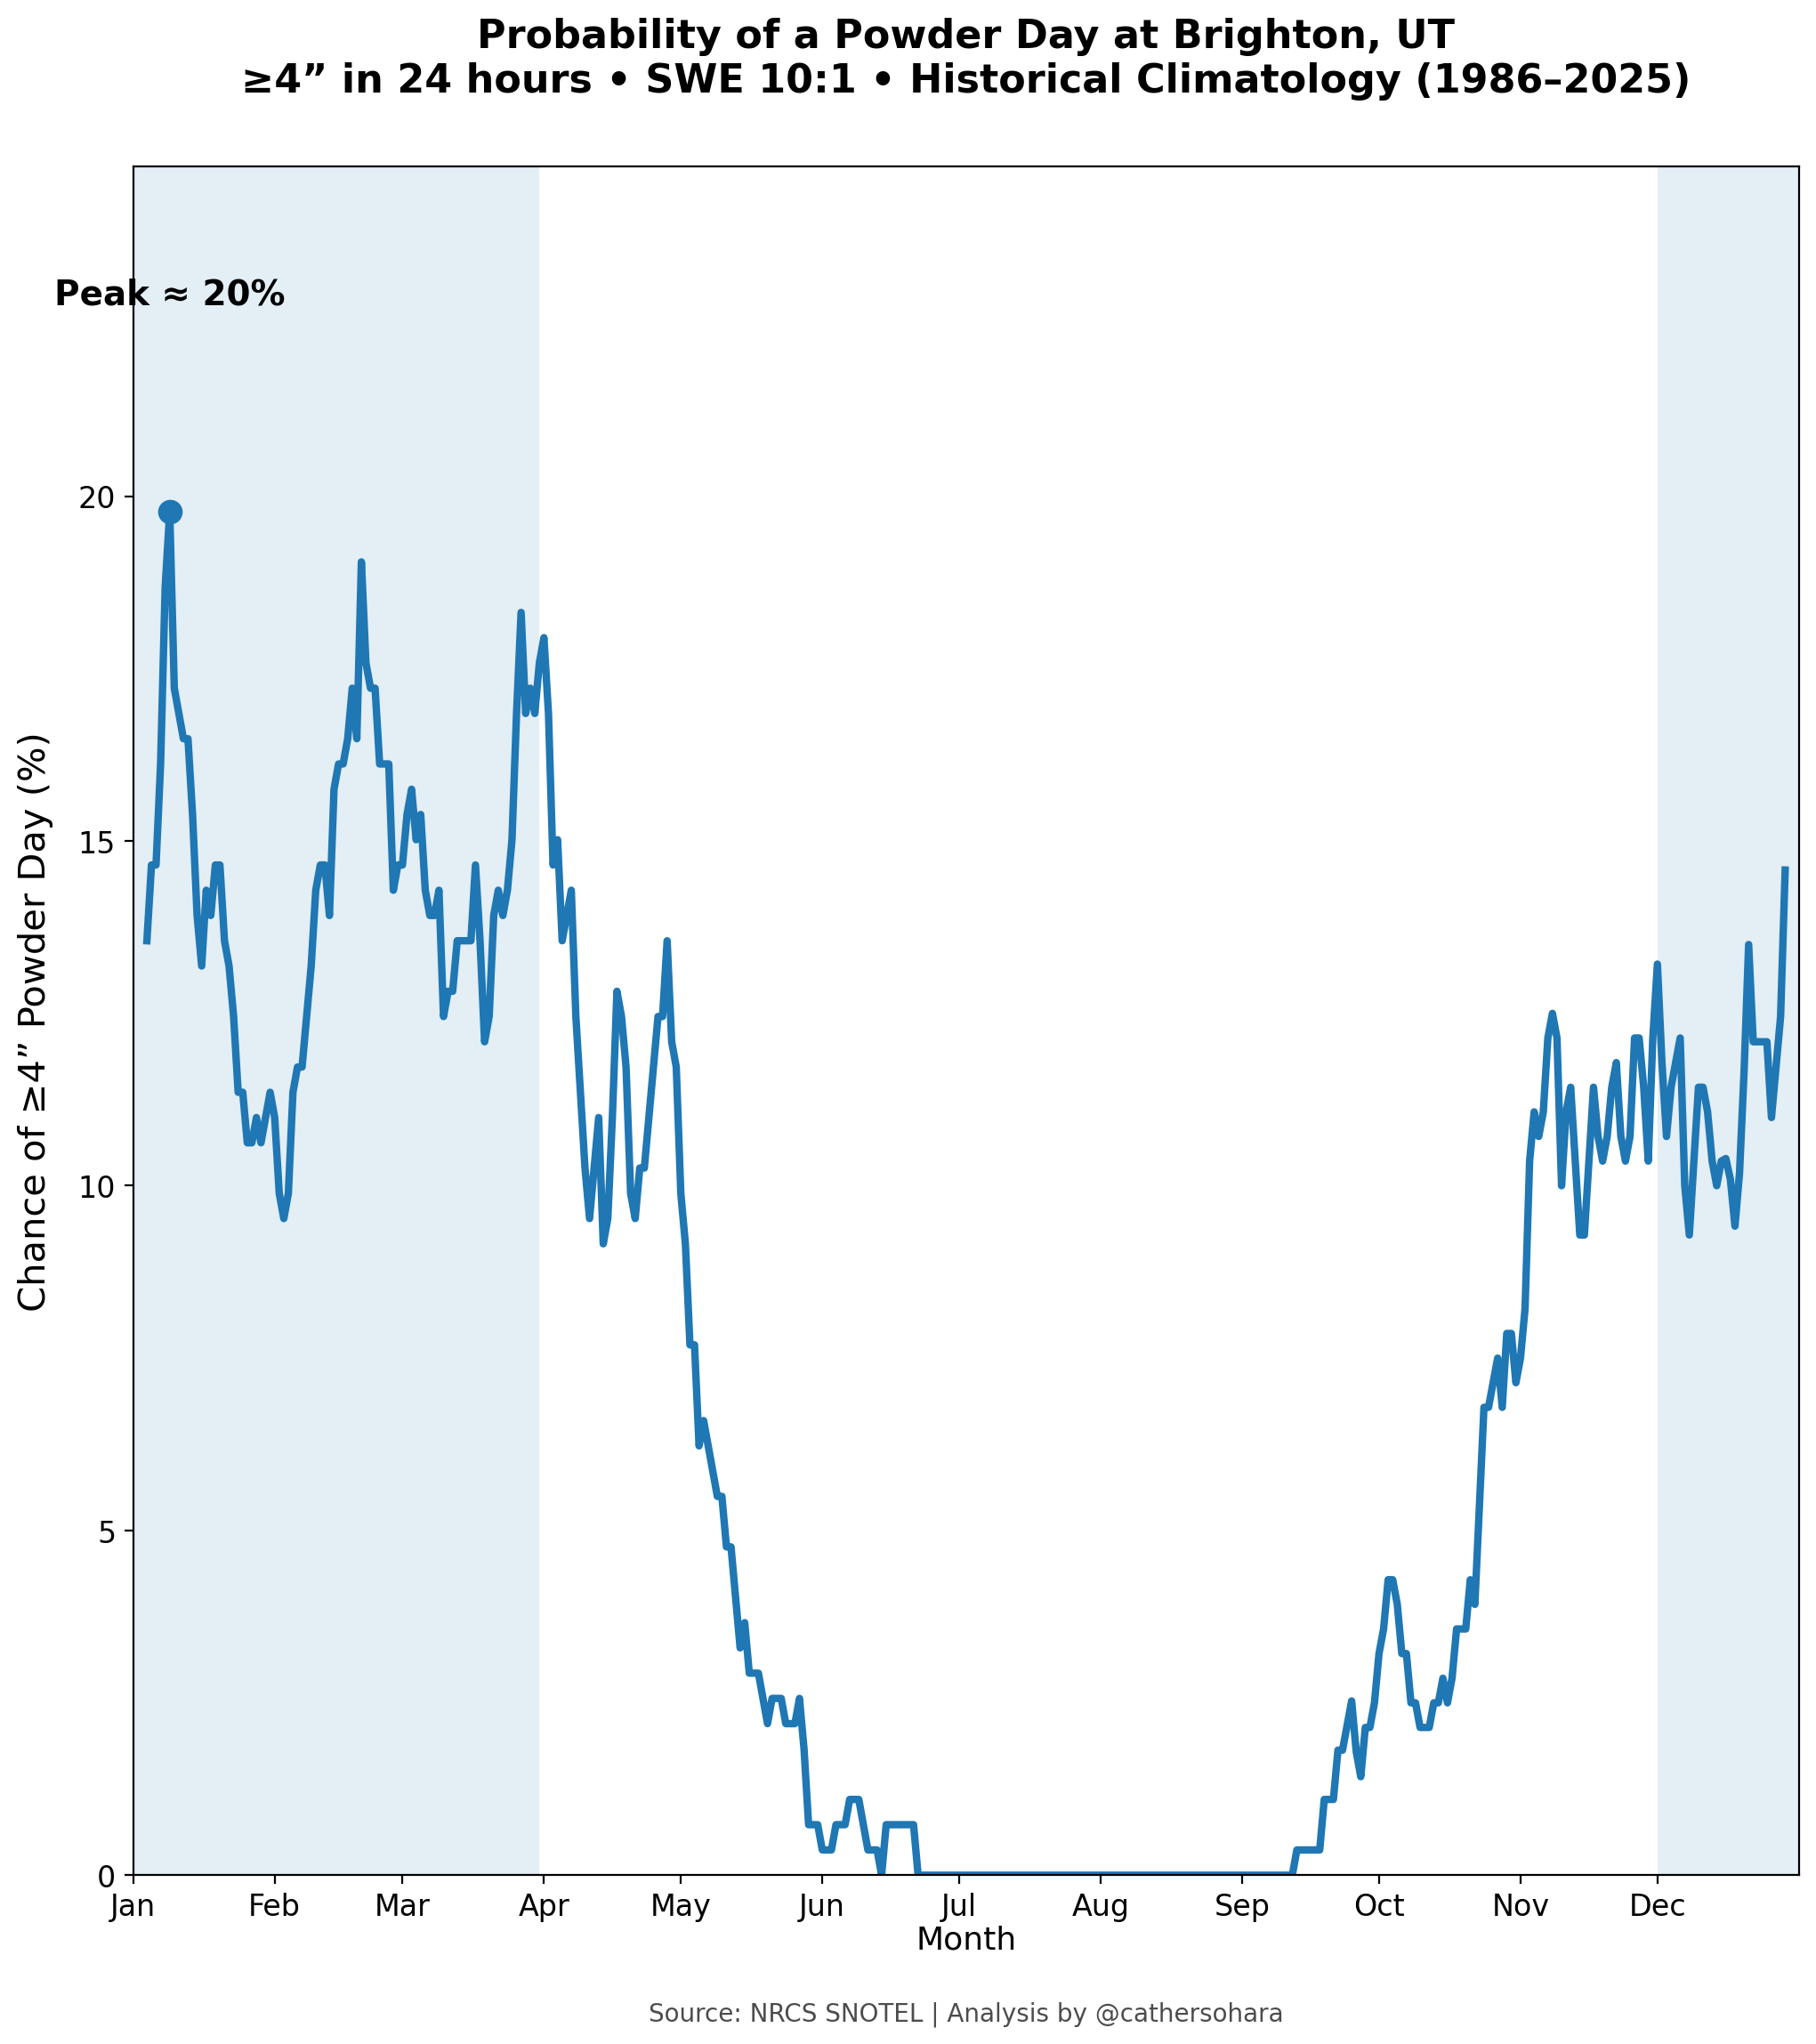

In [79]:
fig, ax = plt.subplots(figsize=(12, 12), dpi=200)

# main line + peak
ax.plot(x, y, linewidth=3)
ax.scatter(peak_day, peak_value, s=80, zorder=5)

ax.set_xlim(1, 366)
ax.set_ylim(0, np.nanmax(y) + 5)

# labels
ax.set_ylabel("Chance of ≥4” Powder Day (%)", fontsize=15, labelpad=10)
ax.set_xlabel("Month", fontsize=13, labelpad=1)

# month ticks
month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
ax.set_xticks(month_days)
ax.set_xticklabels(month_labels, fontsize=12)
ax.tick_params(axis="y", labelsize=12)

# footer
ax.text(
    0.5,
    -0.085,
    "Source: NRCS SNOTEL | Analysis by @cathersohara",
    transform=ax.transAxes,
    ha="center",
    fontsize=10,
    alpha=0.7
)


# season shading (lighter)
ax.axvspan(1, 90, alpha=0.12)
ax.axvspan(335, 366, alpha=0.12)

# peak annotation
ax.text(
    peak_day,
    peak_value + 3,
    f"Peak ≈ {peak_value:.0f}%",
    ha="center",
    fontsize=14,
    weight="bold"
)

fig.suptitle(
    "Probability of a Powder Day at Brighton, UT\n"
    "≥4” in 24 hours • SWE 10:1 • Historical Climatology (1986–2025)",
    x=0.57,
    y=0.95,
    ha='center',
    va='top',
    fontsize=16,
    weight="bold",
   # y=0.938,
    linespacing=1.2
)

# Add a suptitle and customize its position
#fig.suptitle('My Custom Suptitle', 
             #x=0.5,    # horizontal alignment (0=left, 0.5=center, 1=right)
             #y=0.95,   # vertical position (default ~0.98)
             #ha='center',  # horizontal alignment: 'left', 'center', 'right'
             #va='top',     # vertical alignment: 'bottom', 'center', 'top', 'baseline'
             #fontsize=16,
             #color='darkblue')

# Adjust the layout so the subplots and suptitle don't overlap
fig.tight_layout(rect=[0, 0, 1, 0.93])

# spacing control (THIS replaces tight_layout)
fig.subplots_adjust(
    top=0.88,
    bottom=0.08,
    left=0.18,
    right=0.96
)


# export
plt.savefig(
    "brighton_powder_probability_vertical.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


<Figure size 640x480 with 0 Axes>

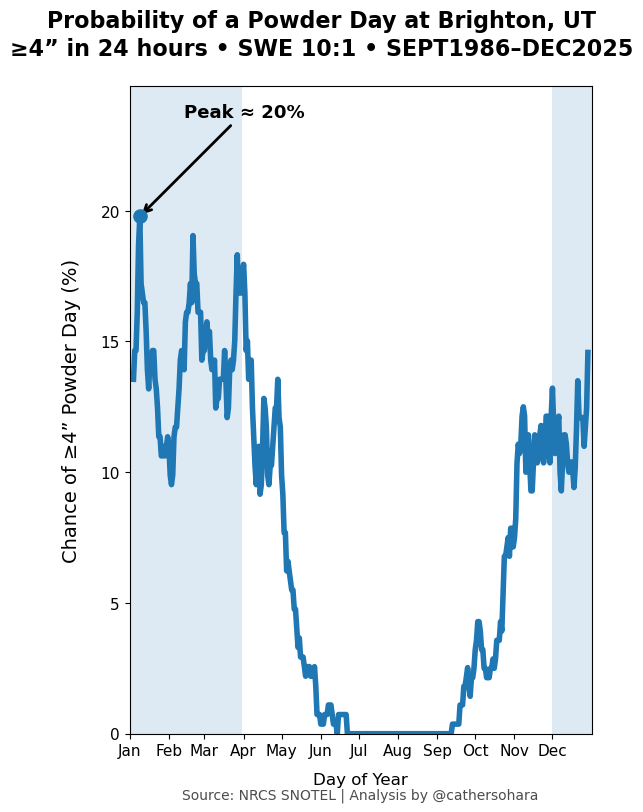

In [83]:
fig, ax = plt.subplots(figsize=(6, 9))  # 4:5–friendly vertical

ax.scatter(peak_day, peak_value, s=90, zorder=6)

ax.plot(
    x,
    y,
    linewidth=4
)

ax.set_ylim(0, np.nanmax(y) + 5)
ax.set_xlim(1, 366)

# Axis labels
ax.set_ylabel("Chance of ≥4” Powder Day (%)", fontsize=14, labelpad=14)
ax.set_xlabel("Day of Year", fontsize=12, labelpad=10)

# Month ticks
month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

ax.set_xticks(month_days)
ax.set_xticklabels(month_labels, fontsize=11)
ax.tick_params(axis="y", labelsize=11)

# Highlight core powder season
ax.axvspan(335, 366, alpha=0.15)
ax.axvspan(1, 90, alpha=0.15)

ax.annotate(
    f"Peak ≈ {peak_value:.0f}%",
    xy=(peak_day, peak_value),
    xytext=(peak_day + 35, peak_value + 4),
    textcoords="data",
    arrowprops=dict(
        arrowstyle="->",
        linewidth=2
    ),
    fontsize=13,
    weight="bold",
    ha="left",
    va="center"
)

fig.suptitle(
    "Probability of a Powder Day at Brighton, UT\n"
    "≥4” in 24 hours • SWE 10:1 • SEPT1986–DEC2025",
    fontsize=16,
    weight="bold",
    y=0.965,
    linespacing=1.25
)

ax.text(
    0.5,
    -0.10,
    "Source: NRCS SNOTEL | Analysis by @cathersohara",
    transform=ax.transAxes,
    ha="center",
    fontsize=10,
    alpha=0.7
)

fig.subplots_adjust(
    top=0.88,
    bottom=0.16,
    left=0.18,
    right=0.95
)

plt.savefig(
    "brighton_powder_probability_instagram.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()
